In [9]:
import sys,os
sys.path.append("/home/edo/Software/TESI/AstroCosmoComputational/Students/Martinelli_Edoardo/")
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from numpy.linalg import inv
from numpy.linalg import multi_dot
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, cm
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",})
# Import distances class
from pyACC.cosmology import *
# Import integration class
from pyACC.Calculus import *
import scipy as sp
# Import the plotting module
from getdist import plots, MCSamples
import getdist

In [10]:
# reading of data and covariance matrix

h = open('SNIa_covariance.txt', 'r')
lines=h.readlines()
lines=np.array(lines)
n=lines.size
Cov=np.zeros((n,n))
Cov=np.loadtxt("SNIa_covariance.txt")
Cov_in=inv(Cov) # this is the inverse of cov matrix
det_cov=np.linalg.det(Cov)
h.close()
# Cov is a n x n npMatrix


# Now I read the data file
f = open('SNIa_data.txt', 'r')
lines=f.readlines()
lines=np.array(lines)
mu_Dl=np.zeros((n,2))
mu_Dl=np.loadtxt("SNIa_data.txt")
Mu_Dl=[]
for i in range(0,n):
    Mu_Dl.append(mu_Dl[i][1])
Mu_Dl=np.array(Mu_Dl)
Redz=[]
for i in range(0,n):
    Redz.append(mu_Dl[i][0])
Redz=np.array(Redz)
f.close()

# mu_Dl is a n x 2 matrix with the first coloumn as the magnitude and the second one the redshift
# Redz is a 1x n vector with redshifts


We have now to choose a posterior distribution of parameter, having data. We choose a gaussian Likelihood:

$ln\left(L(\theta)\right)=-\frac{1}{2}\left(x-\mu(\theta) \right)^T\Sigma^{-1}\left(x-\mu(\theta) \right)$

where x are data and mu is the theoretical distance modulus as function of parameters $\theta$.

In [21]:
NORM=(1/(np.sqrt(2*np.pi*det_cov)))**n
print("Normalization factor is ",NORM)

Normalization factor is  inf


/tmp/ipykernel_9285/751631626.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  NORM=(1/(np.sqrt(2*np.pi*det_cov)))**n


In [22]:
def logLH(h0,OmM):
    x = (Mu_Dl-distance_modulus(Redz,H0=h0,omegaM=OmM,omegaLam=1-OmM))
    return 0.5*(-multi_dot([x,Cov_in,x])+(multi_dot([np.ones(n),Cov_in,x]))**2/(multi_dot([np.ones(n),Cov_in,np.ones(n)])))
def LH(h0,OmM):
    return np.exp(logLH(h0,OmM))
'''
def LH_not_marg(h0,OmM):
    x = (Mu_Dl-distance_modulus(Redz,H0=h0,omegaM=OmM,omegaLam=1-OmM))
    return np.exp(-0.5*multi_dot([x,Cov_in,x]))*NORM
'''


In [13]:
# LH is marginalized on the intrinsic luminosity of Supernovae
likelihood =lambda h0,OmM: LH(h0,OmM)
L_H = Funct(likelihood)
ext_HO= 70
ext_OM= 0.37
ext_IN= np.array([66,0.27])
ext_SUP= np.array([ext_HO,ext_OM])
norm = L_H.Int(ext_IN,ext_SUP)
print(norm)
NORM_backup=5.2340620336207494e-213


Function object created, you've inserted a  <class 'function'>  function with  2  variables
5.2340620336207494e-213


In [14]:
#NORM=663272866.1452382
pdf= lambda h0,OmM: LH(h0,OmM)/norm

In [16]:
H0_0=67
Omm_0=0.3
X0=np.array([H0_0,Omm_0])
Nint=500

In [17]:
Ds=np.array([0.1,0.01])
result_MH_lin,eff_MH_lin=Metropolis_Hastings(pdf,X0,Nint,Ds,type='flat')
H0_res_lin=result_MH_lin[:,0]
Omm_res_lin=result_MH_lin[:,1]

Function object created, you've inserted a  <class 'function'>  function with  2  variables


Removed no burn in


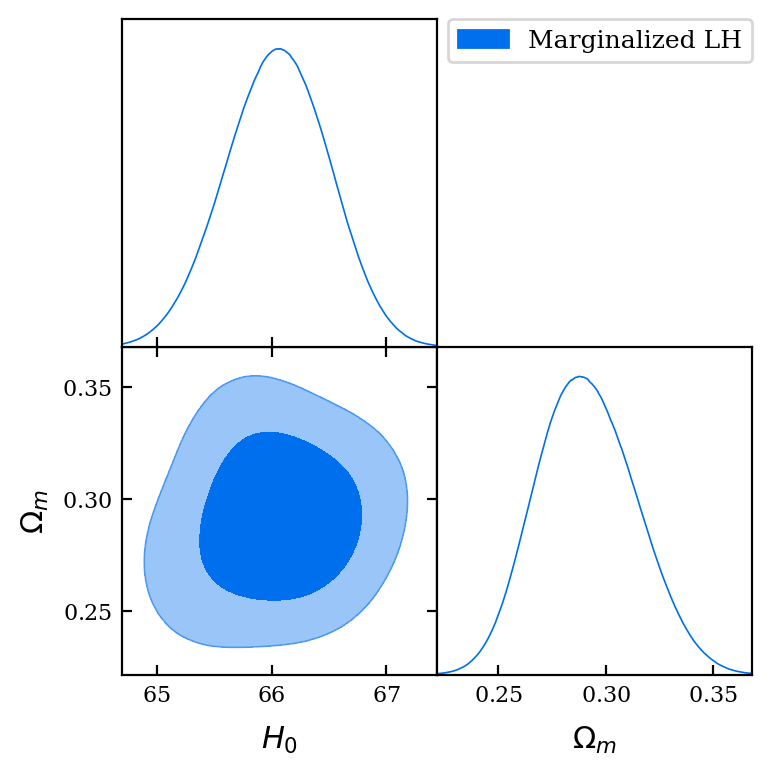

In [28]:
sam_lin=MCSamples(samples=result_MH_lin,names=['h0','OmM'],labels=['H_0','\Omega_m'],label='Marginalized LH')
g = plots.get_subplot_plotter()
g.triangle_plot(sam_lin, filled=True,legend_labels=['Marginalized LH'],legend_loc='upper right')
